# Letters
The main goal of this exercise is to train a diffusion model to generate letters images.

We will use the az-handwritten-alphabets-in-csv-format dataset by sachinpatel21 on Kaggle

In [1]:
import torch
import diffusers
import matplotlib.pyplot as plt
from datasets import load_dataset
from torchvision import transforms
import kagglehub
from pandas import read_csv, concat
from pandas import DataFrame

from PIL import Image
import numpy as np

## Data
Download, transform and import images from dataset to program

In [2]:
# Import the Dataset from kaggle and load on a Tensor
Nist_dataset = kagglehub.dataset_download("sachinpatel21/az-handwritten-alphabets-in-csv-format")

chunksize = 250

# the list that contains all the dataframes
list_of_dataframes = []

for df in read_csv(Nist_dataset+"/A_Z Handwritten Data.csv", chunksize=chunksize):
    # process your data frame here
    # then add the current data frame into the list
    list_of_dataframes.append(df)

# if you want all the dataframes together, here it is
handwritten_alphabet = concat(list_of_dataframes)


In [3]:
class HandwrittenAlphabetDataset(torch.utils.data.Dataset):
    def __init__(self, Alphabet_dataframe:DataFrame, img_size: int, transform=None):
        """
        Args:
            csv_file (string): Ruta al archivo CSV.
            transform (callable, optional): Transformación opcional para aplicar a la imagen.
        """
        self.data = Alphabet_dataframe
        self.transform = transform
        self.img_size = img_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Obtener la etiqueta y los píxeles
        label = self.data.iloc[idx, 0]
        pixels = self.data.iloc[idx, 1:].values.astype(np.uint8)

        # Reformar los píxeles en una imagen (ej. 28x28)
        img = pixels.reshape(self.img_size, self.img_size)
        img = Image.fromarray(img) # Convertir a objeto PIL Image

        if self.transform:
            img = self.transform(img)

        return img, label

In [4]:
image_size = 32

#Prepare images to load to the net

preprocess = transforms.Compose(
    [
        transforms.Resize((image_size,image_size)),
        transforms.ToTensor(),              #Convert to Tensor
        transforms.Normalize([0.5],[0.5])   #Map tp -1 to 1
    ]
)

def transform(examples):
    examples = preprocess(examples)
    return examples


In [5]:
# Create and Split the dataset on Train, Validation and Test Datasets
dataset = HandwrittenAlphabetDataset(handwritten_alphabet, 28, transform)

train,val,test = torch.utils.data.random_split(dataset,[0.5,0.2,0.3])

### A little fnct to show easily images

In [6]:
def show_images(images_tensor:torch.tensor):
    n_dims = images_tensor.dim()
    
    if n_dims in (2,3):
        x_cat = images_tensor

    elif n_dims == 4:
        x_list = [img for img in images_tensor]
        x_cat = torch.cat(x_list,dim=2)
    
    else:
        raise SyntaxError("The dimensions of images_tensor must be between 2 and 4")

    if n_dims != 2:
        if x_cat.shape[0] == 1:
            plt.imshow(x_cat.movedim(0,-1),cmap="gray");
        else:
            plt.imshow(x_cat.movedim(0,-1));
    else:
        plt.imshow(x_cat,cmap="gray");

In [70]:
def show_images_list(images_list:list[torch.Tensor]) -> None:

    images_tensor = torch.concat(images_list,dim=0)

    # return images_tensor
    show_images(images_tensor.unsqueeze(1))

## Preparing images to the net

In [7]:
#   Create the Dataloader
batch_size = 256

train_dataloader = torch.utils.data.DataLoader(
    train,
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    val,
    batch_size=batch_size,
    shuffle=True
)


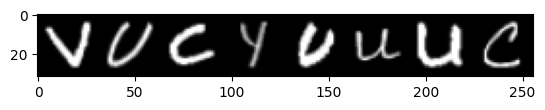

In [8]:
show_images(next(iter(train_dataloader))[0][:8])

## Add Noise

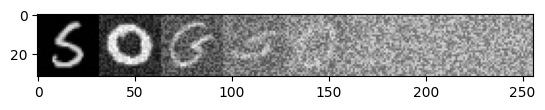

In [9]:
scheduler = diffusers.DDPMScheduler(
    num_train_timesteps=1000, beta_start=0.001, beta_end=0.02
)

# Create a tensor with 8 evenly spaced values from 0 to 999
timesteps = torch.linspace(0, 999, 8).long()

# We load 8 images from the dataset and
# add increasing amounts of noise to them
batch = next(iter(train_dataloader))
x = batch[0][:8]
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)

show_images(noised_x)

## U-Net

In [10]:
from diffusers import UNet2DModel

model = UNet2DModel(
    in_channels=1,  # 1 channels for grey scale
    sample_size=image_size,  # Specify our input size
    # The number of channels per block affects the model size
    block_out_channels=(32, 64, 128, 256),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
        ),
    out_channels=1

).cuda()

# Pass a batch of data through to make sure it works. The dimensions of tensors must be the same
with torch.inference_mode():
    out = model(noised_x.cuda(), timestep=timesteps.cuda()).sample

print(noised_x.shape)
print(out.shape)

torch.Size([8, 1, 32, 32])
torch.Size([8, 1, 32, 32])


## Training Loops

In [11]:
from torch.nn import functional as F
n_epochs = 5
lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
loss_fn = F.mse_loss
losses = []

In [12]:
from torch import nn
def train_loop(loader:torch.utils.data.DataLoader, model : nn.Module, scheduler: diffusers.schedulers, optimizer:torch.optim, loss_fn:callable):
    nlotes = len(loader)
    # train_size = len(loader.dataset)

    model.train()   #Preparo el modelo para el entrenamiento

    train_losses = 0
    losses_list = []

    # losses_list = []

    for nlote,x in enumerate(loader):
        x = x[0].cuda()

        ## Noise
        # Make noise
        noise = torch.randn_like(x).cuda()

        # Create random timesteps to the training
        timesteps = torch.randint(
            0,
            scheduler.config.num_train_timesteps,
            (x.shape[0],)
        ).long().cuda()

        # Add Noise to images
        noisy_x = scheduler.add_noise(x,noise,timesteps)

        ## Forward Pass
        noise_pred = model(noisy_x, timesteps, return_dict = False)[0]
        
        
        ## Back-propagation
        # Calc of loss
        loss = loss_fn(noise_pred, noise)    #Calculo de loss
        
        # Save Loss
        losses_list.append(loss.item())

        # Steps of training
        loss.backward()             #Calculo de gradiente
        optimizer.step()            #Actualización de parámetros
        optimizer.zero_grad()       #Limpieza del optimizador

        #Guardamos algunas características para plotear al final
        train_losses += loss.item()

        #Muestra del proceso
        if nlote % 10 == 0:
            print("Nº de lote:\t",nlote)
            print("Loss:\t\t\t",loss.item())
            print()

    train_losses /= nlotes
    print()
    print("\tAccuracy/Loss Promedio")
    print(f"\t\tEntrenamiento: {train_losses:>8f}")

    return losses_list

In [13]:
def val_loop(loader:torch.utils.data.DataLoader, model:nn.Module, scheduler: diffusers.schedulers, loss_fn:callable):
    
    # val_size = len(loader.dataset)
    nlotes = len(loader)

    model.eval()         #Preparo el modelo para inferencia

    val_losses = 0
    losses_list = []

    with torch.inference_mode():       #Cancelo el calculo del gradiente
        for x in loader:
            
            x = x[0].cuda()

            ## Noise
            noise = torch.randn_like(x)

            timesteps = torch.randint(
                0,
                scheduler.config.num_train_timesteps,
                (x.shape[0],)
            ).long().cuda()

            noisy_x = scheduler.add_noise(x, noise, timesteps)

            noise_pred = model(noisy_x, timesteps, return_dict=False)[0]       # Inferencia
            
            loss = loss_fn(noise_pred, noise)

            val_losses += loss.item()
            losses_list.append(loss.item())

    val_losses /= nlotes

    print(f"\t\t Validación: {val_losses:>8f}")

    return losses_list


## The training

In [14]:
train_loss = []
val_loss = []
for epoch in range(n_epochs):
    print(f"Iteración: {(epoch + 1)} / {n_epochs} -----------------------------")
    
    #Train
    train_loss  += train_loop(train_dataloader,model,scheduler,optimizer,loss_fn)
    
    #Validation
    val_output = val_loop(val_dataloader,model,scheduler,loss_fn)
    val_loss += val_output

print("Finalizado entrenamiento del modelo!")

Iteración: 1 / 5 -----------------------------
Nº de lote:	 0
Loss:			 1.140864372253418

Nº de lote:	 10
Loss:			 0.4426865577697754

Nº de lote:	 20
Loss:			 0.23623791337013245

Nº de lote:	 30
Loss:			 0.167633056640625

Nº de lote:	 40
Loss:			 0.12337898463010788

Nº de lote:	 50
Loss:			 0.10790841281414032

Nº de lote:	 60
Loss:			 0.09254227578639984

Nº de lote:	 70
Loss:			 0.08604036271572113

Nº de lote:	 80
Loss:			 0.08123025298118591

Nº de lote:	 90
Loss:			 0.07882116734981537

Nº de lote:	 100
Loss:			 0.07280315458774567

Nº de lote:	 110
Loss:			 0.06227702647447586

Nº de lote:	 120
Loss:			 0.06142278015613556

Nº de lote:	 130
Loss:			 0.057197339832782745

Nº de lote:	 140
Loss:			 0.054677508771419525

Nº de lote:	 150
Loss:			 0.04622901231050491

Nº de lote:	 160
Loss:			 0.04873207211494446

Nº de lote:	 170
Loss:			 0.04797416552901268

Nº de lote:	 180
Loss:			 0.04845377057790756

Nº de lote:	 190
Loss:			 0.04826762154698372

Nº de lote:	 200
Loss:			 0

In [15]:
torch.save(model.state_dict(),"First_train.pth")

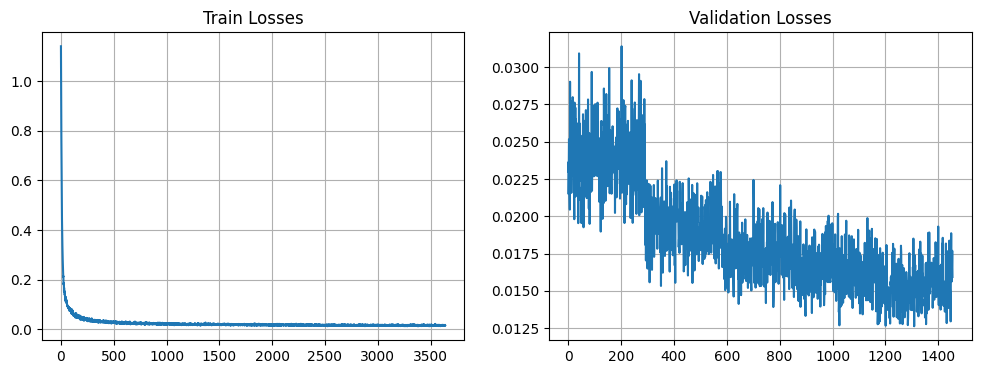

In [16]:
plt.subplots(1,2,figsize=(12,4))

plt.subplot(1,2,1)
plt.title("Train Losses")
plt.plot(range(len(train_loss)),train_loss);
plt.grid()

plt.subplot(1,2,2)
plt.title("Validation Losses")
plt.plot(range(len(val_loss)),val_loss);
plt.grid()

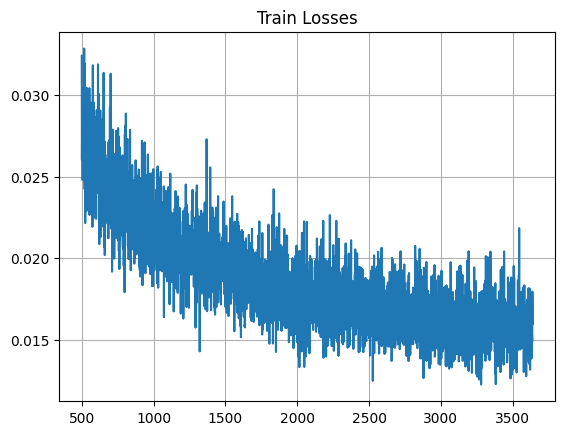

In [18]:
plt.title("Train Losses")
plt.plot(range(500,len(train_loss)),train_loss[500:]);
plt.grid()

## Generations of images

In [76]:
pipeline = diffusers.DDPMPipeline(unet=model, scheduler=scheduler)
ims = pipeline(batch_size=8).images

  0%|          | 0/1000 [00:00<?, ?it/s]

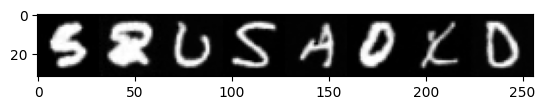

In [77]:
ToTensor = transforms.ToTensor()
imgs_tensor = [ToTensor(img) for img in ims]
show_images_list(images_list=imgs_tensor)